In [ ]:
#pip install -U -q tensorflow tensorflow_datasets

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = 'data1'

data_dir = pathlib.Path(DATASET_PATH)


In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

print('Commands:', commands)

Commands: ['aadi' 'adugu' 'barabar' 'chinna' 'kai' 'muli' 'perugu' 'pora' 'pyar'
 'rang' 'safar' 'vela']


In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 15650 files belonging to 12 classes.
Using 12520 files for training.
Using 3130 files for validation.

label names: ['aadi' 'adugu' 'barabar' 'chinna' 'kai' 'muli' 'perugu' 'pora' 'pyar'
 'rang' 'safar' 'vela']


In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
train_ds

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
val_ds

<_ShardDataset element_spec=(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


In [11]:
label_names[[0,1,2]]

array(['aadi', 'adugu', 'barabar'], dtype='<U7')

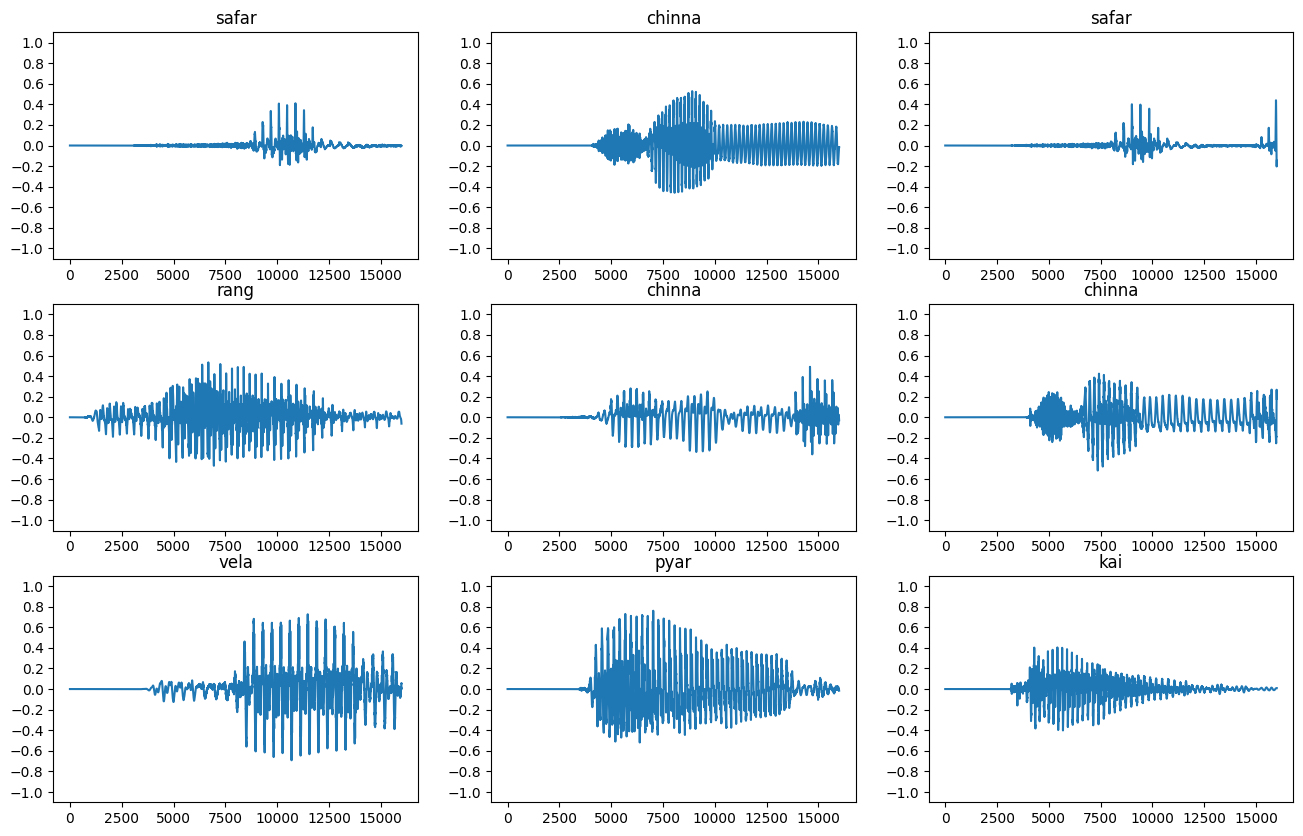

In [12]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [13]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
    waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [14]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: safar
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: chinna
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: safar
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [15]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

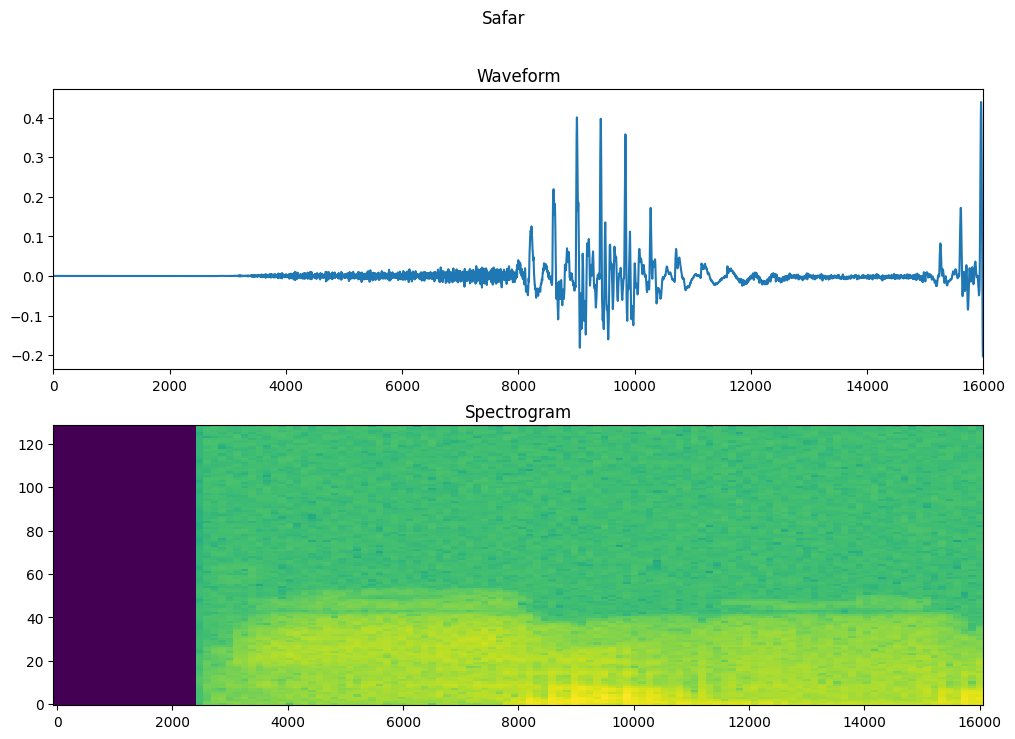

In [16]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [17]:
def make_spec_ds(ds):
    return ds.map(map_func=lambda audio,label: (get_spectrogram(audio), label),num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [19]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

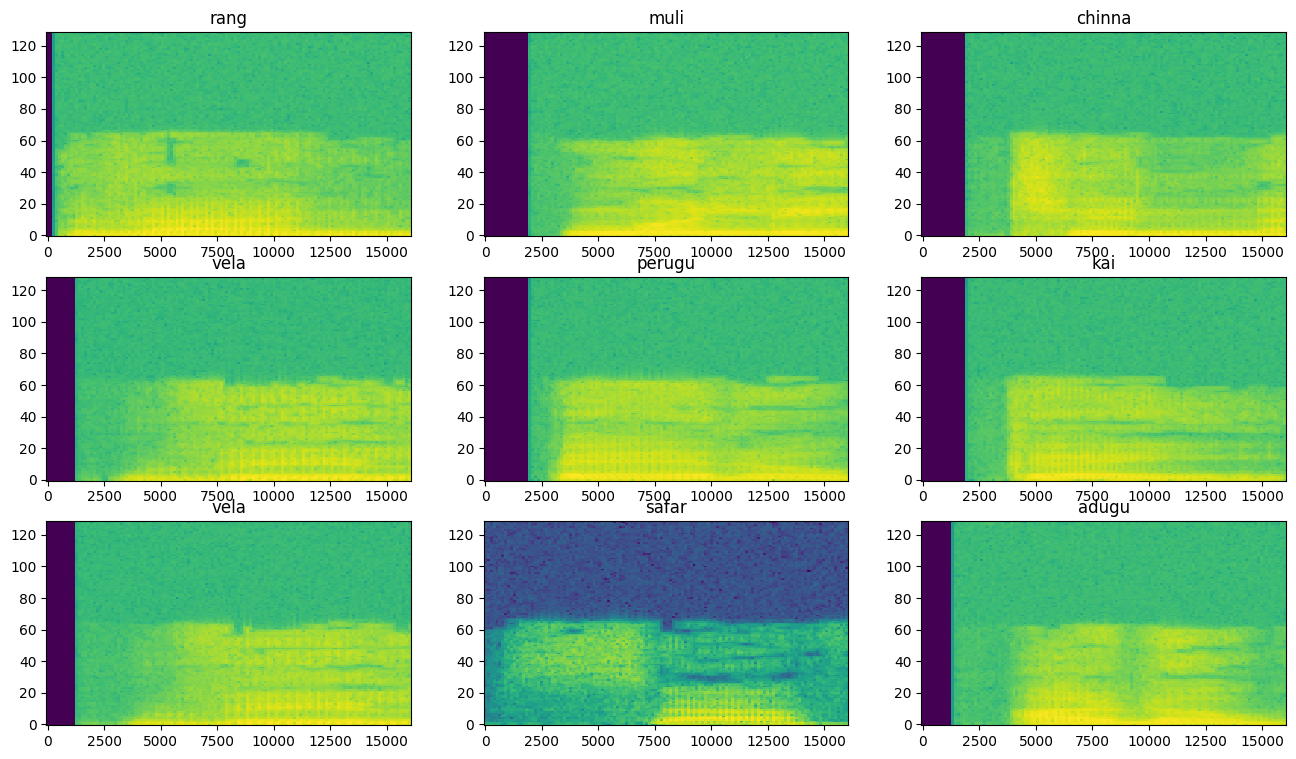

In [20]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [22]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [24]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
196/196 [==============================] - 23s 114ms/step - loss: 0.2749 - accuracy: 0.9169 - val_loss: 0.0168 - val_accuracy: 0.9993
Epoch 2/10
196/196 [==============================] - 19s 98ms/step - loss: 0.0212 - accuracy: 0.9938 - val_loss: 0.0236 - val_accuracy: 0.9993
Epoch 3/10
196/196 [==============================] - 19s 95ms/step - loss: 0.0144 - accuracy: 0.9954 - val_loss: 0.0192 - val_accuracy: 0.9993
Epoch 3: early stopping


Text(0, 0.5, 'Accuracy [%]')

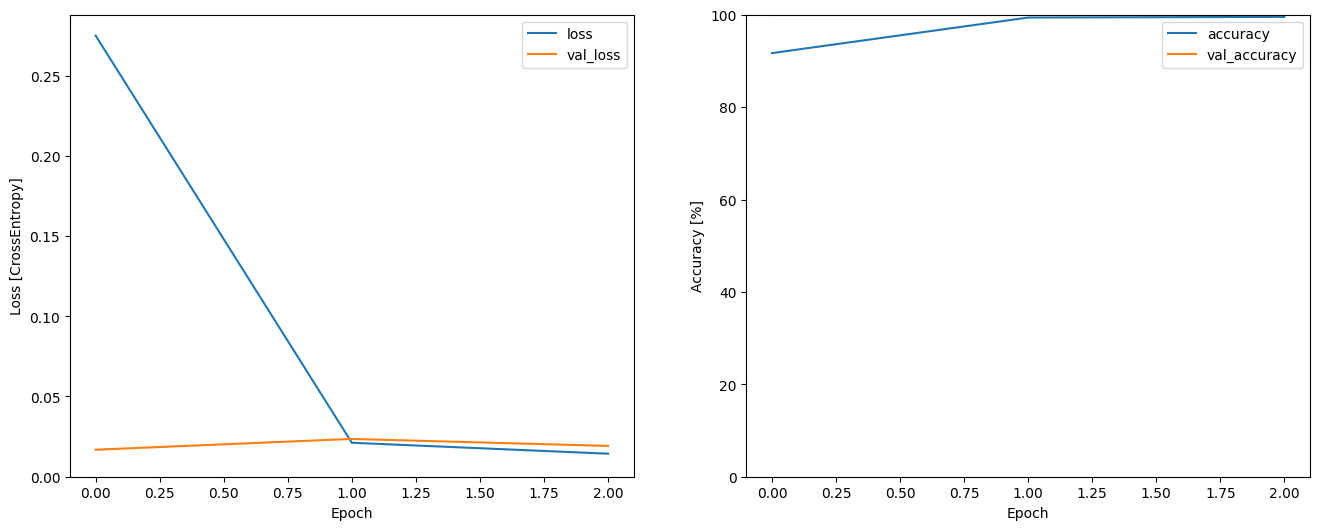

In [25]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [26]:
model.evaluate(test_spectrogram_ds, return_dict=True)

25/25 [==============================] - 1s 47ms/step - loss: 9.2562e-05 - accuracy: 1.0000


{'loss': 9.256217890651897e-05, 'accuracy': 1.0}

In [27]:
y_pred = model.predict(test_spectrogram_ds)

25/25 [==============================] - 0s 16ms/step


In [28]:
y_pred = tf.argmax(y_pred, axis=1)

In [29]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

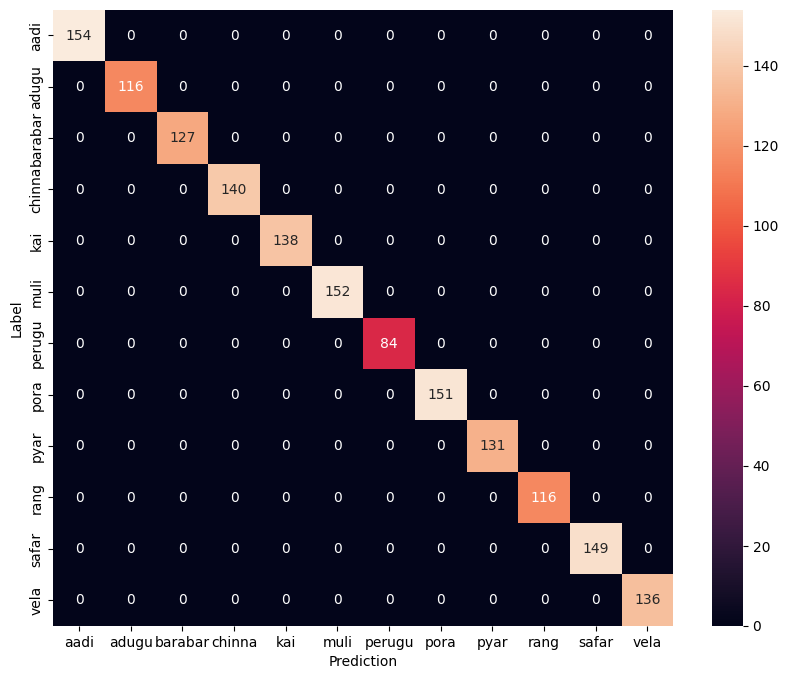

In [30]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

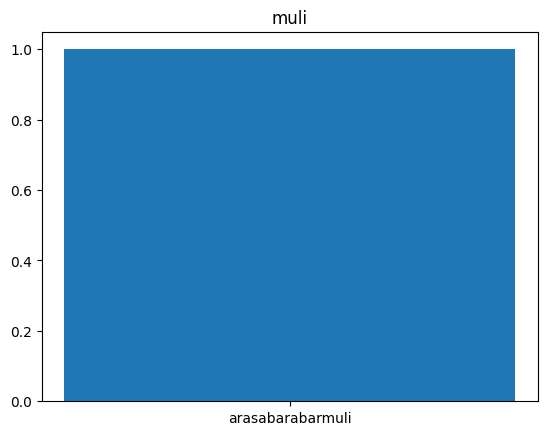

In [31]:
x = '1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels =['arasa'  'barabar' 'muli']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('muli')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [32]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        # Accept either a string-filename or a batch of waveforms.
        # YOu could add additional signatures for a single wave, or a ragged-batch. 
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
           x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))
    @tf.function
    def __call__(self, x):
        # If they pass a string, load the file and decode it. 
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]
    
        x = get_spectrogram(x)  
        result = self.model(x, training=False)
    
        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [33]:
export = ExportModel(model)
export(tf.constant(str('1.wav')))

{'predictions': <tf.Tensor: shape=(1, 12), dtype=float32, numpy=
 array([[  5.2593236,  -9.179846 ,   2.2307107,   1.4795188,  -3.6312819,
          32.738926 , -14.187457 ,   6.948965 , -18.817556 ,  -5.043351 ,
          -3.096089 , -10.252366 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'muli'], dtype=object)>}

In [34]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


{'predictions': <tf.Tensor: shape=(1, 12), dtype=float32, numpy=
 array([[  5.2593236,  -9.179846 ,   2.2307107,   1.4795188,  -3.6312819,
          32.738926 , -14.187457 ,   6.948965 , -18.817556 ,  -5.043351 ,
          -3.096089 , -10.252366 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'muli'], dtype=object)>}

In [35]:
a=export(tf.constant(str('1.wav')))

In [36]:
s=str(a['class_names'])

In [37]:
i1=s.index("b'")+2

In [38]:
i2=s.index("']")

In [39]:
cname=s[i1:i2]
cname

'muli'

In [40]:
import pandas as pd
df=pd.read_excel('word_meanings.xlsx')
df

,Word,telugu,tamil,hindi,urdu,Marathi,Kannada
0,puli,tiger,tamarind,NaN,NaN,NaN,NaN
1,kodi,chicken,flag/banner,NaN,NaN,NaN,NaN
2,ma,month,great/big,NaN,NaN,NaN,NaN
3,pora,to search,fight/battle,NaN,NaN,NaN,NaN
4,maata,word/speech,cow,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72,dhoka,NaN,NaN,betrayal,NaN,danger,NaN
73,shikka,NaN,NaN,coin,NaN,stamp/seal,NaN
74,barabar,NaN,NaN,equal,NaN,correct,NaN
75,muli,NaN,NaN,raddish,NaN,girls,NaN


In [41]:
def get_properties(word):
    global df
    c=0
    if word in df['Word'].values:
        print(f"{word} is present in the 'Word' column.")
        row_number = df.index[df['Word'] == word].tolist()[0] + 1
        print(row_number-1)
        print(df.iloc[row_number-1])
        telugu=df.iloc[row_number-1]['telugu']
        tamil=df.iloc[row_number-1]['tamil']
        hindi=df.iloc[row_number-1]['hindi']
        urdu=df.iloc[row_number-1]['urdu']
        Marathi=df.iloc[row_number-1]['Marathi']
        Kannada=df.iloc[row_number-1]['Kannada']
        
        f=open('details.txt','w')
        det=''
        
        telugu="Telugu :"+str(telugu)
        if 'nan' in telugu:
            telugu=''
            
        tamil="Tamil :"+str(tamil)
        if 'nan' in tamil:
            tamil=''
        hindi="Hindi :"+str(hindi)
        if 'nan' in hindi:
            hindi=''
        urdu="Urdu :"+str(urdu)
        if 'nan' in urdu:
            urdu=''
        Marathi="Marathi :"+str(Marathi)
        if 'nan' in Marathi:
            Marathi=''
        Kannada="Kannada :"+str(Kannada)
        if 'nan' in Kannada:
            Kannada=''
        det="Meaning of "+word+" in other language '"+telugu+"'\n'"+tamil+"'\n'"+hindi+"'\n'"+urdu+"'\n'"+Marathi+"'\n'"+Kannada
        
         
        print('telugu',telugu)
        print('tamil',tamil)
        print('hindi',hindi)
        print('urdu',urdu)
        print('Marathi',Marathi)
        print('Kannada',Kannada)
        
        f.write(str(telugu)+'##'+str(tamil)+'##'+str(hindi)+'##'+str(urdu)+'##'+str(Marathi)+'##'+str(Kannada))
        f.close()
        #det='Telugu : '+str(telugu)+'---Tamil  '+str(tamil)+'---Hindi  '+str(hindi)+'---Urdu  '+str(urdu)+'--Marathi  '+str(Marathi)+'---Kannada'+str(Kannada)
        det.replace('nan','NA')
        return det
    else:
        print(f"{word} is not present in the 'Word' column.")
        return 'No Record'

In [42]:
from pydub import AudioSegment
import os

def convert_wav_to_mono(input_folder, output_folder):
    # Iterate through each WAV file in the input folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".wav"):
            # Load the WAV file
            audio = AudioSegment.from_wav(os.path.join(input_folder, file_name))
           
            # Convert stereo to mono
            audio = audio.set_channels(1)
           
            # Output file path for the mono WAV file
            #output_path = os.path.join(output_folder, os.path.splitext(file_name)[0] + "_mono.wav")
            output_path = os.path.join(output_folder+"1.wav")
            # Export the audio to mono WAV format
            audio.export(output_path, format="wav")

C:\Users\91734\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [43]:
def predict(apath):
    print('predicting ',apath)
    a=export(tf.constant(str(apath)))
    s=str(a['class_names'])
    i1=s.index("b'")+2
    i2=s.index("']")
    cname=s[i1:i2]
    return cname
    

In [44]:
'''
imported1 = tf.saved_model.load("saved")
def predict(apath):
    global imported1
    result=imported1(waveform[tf.newaxis, :])
    print(result)


'''


'\nimported1 = tf.saved_model.load("saved")\ndef predict(apath):\n    global imported1\n    result=imported1(waveform[tf.newaxis, :])\n    print(result)\n\n\n'

In [45]:
predict('1.wav')

predicting  1.wav


'muli'

In [46]:
predict('14.wav')

predicting  14.wav


'rang'

predicting  C:/Users/91734/OneDrive/Desktop/language/data1/bilkul/bil.wav


NotFoundError: Graph execution error:

Detected at node ReadFile defined at (most recent call last):
  File "C:\Users\91734\anaconda3\lib\runpy.py", line 196, in _run_module_as_main

  File "C:\Users\91734\anaconda3\lib\runpy.py", line 86, in _run_code

  File "C:\Users\91734\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\91734\anaconda3\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\91734\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\91734\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start

  File "C:\Users\91734\anaconda3\lib\asyncio\base_events.py", line 603, in run_forever

  File "C:\Users\91734\anaconda3\lib\asyncio\base_events.py", line 1906, in _run_once

  File "C:\Users\91734\anaconda3\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\91734\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue

  File "C:\Users\91734\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one

  File "C:\Users\91734\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell

  File "C:\Users\91734\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\91734\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 411, in do_execute

  File "C:\Users\91734\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 531, in run_cell

  File "C:\Users\91734\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2961, in run_cell

  File "C:\Users\91734\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3016, in _run_cell

  File "C:\Users\91734\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\91734\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3221, in run_cell_async

  File "C:\Users\91734\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3400, in run_ast_nodes

  File "C:\Users\91734\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code

  File "C:\Users\91734\AppData\Local\Temp\ipykernel_7836\2996525803.py", line 1, in <module>

  File "C:\Users\91734\AppData\Local\Temp\ipykernel_7836\3099510471.py", line 7, in __init__

  File "C:\Users\91734\AppData\Local\Temp\ipykernel_7836\3099510471.py", line 14, in __call__

  File "C:\Users\91734\AppData\Local\Temp\ipykernel_7836\3099510471.py", line 15, in __call__

NewRandomAccessFile failed to Create/Open: C:/Users/91734/OneDrive/Desktop/language/data1/bilkul/bil.wav : The system cannot find the path specified.
; No such process
	 [[{{node ReadFile}}]] [Op:__inference___call___6759]

In [48]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav

def record_audio(file_name, duration, samplerate):
    print("Recording...")
    recording = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=2, dtype='int16')
    sd.wait()
    print("Recording stopped.")
    wav.write(file_name, samplerate, recording)

def convert_to_mono(input_file, output_file):
    print("Converting to mono...")
    samplerate, data = wav.read(input_file)
    if len(data.shape) == 2:
        mono_data = np.mean(data, axis=1, dtype=data.dtype)
        wav.write(output_file, samplerate, mono_data)
    else:
        print("Already mono channel.")
'''
# Example usage:
if __name__ == "__main__":
    file_name = "recording_stereo.wav"
    mono_file_name = "recording_mono.wav"
    duration = 2  # in seconds
    samplerate = 44100  # in Hz

    record_audio(file_name, duration, samplerate)
    convert_to_mono(file_name, mono_file_name)

'''



'\n# Example usage:\nif __name__ == "__main__":\n    file_name = "recording_stereo.wav"\n    mono_file_name = "recording_mono.wav"\n    duration = 2  # in seconds\n    samplerate = 44100  # in Hz\n\n    record_audio(file_name, duration, samplerate)\n    convert_to_mono(file_name, mono_file_name)\n\n'

In [49]:
'''
import time

duration = 2  # in seconds
samplerate = 44100  # in Hz
file_name="55.wav"
record_audio('temp/'+file_name,duration, samplerate)
convert_to_mono('temp/'+file_name, 'temp1/'+file_name)
predict('temp1/'+file_name)
    


'''

    

'\nimport time\n\nduration = 2  # in seconds\nsamplerate = 44100  # in Hz\nfile_name="55.wav"\nrecord_audio(\'temp/\'+file_name,duration, samplerate)\nconvert_to_mono(\'temp/\'+file_name, \'temp1/\'+file_name)\npredict(\'temp1/\'+file_name)\n    \n\n\n'

In [51]:
import tkinter as tk
from tkinter import PhotoImage
import pygame
import sounddevice as sd
import soundfile as sf
path='C:/Users/91734/OneDrive/Desktop/language/'
count=0
from tkinter import filedialog
class FullScreenApp:
    def __init__(self, master):
        self.master = master
        master.title("Full Screen App")
        master.attributes('-fullscreen', False)  # Full-screen mode

        # Load images
        #self.image1 = PhotoImage(file=path + "w.png")
        
        

        # Display images
        #self.label1 = tk.Label(master, image=self.image1)
        #self.label1.pack(side="top", fill="both", expand=True)
        #self.label1.bind("<Button-1>", lambda event: self.show_image(self.image1))
        
        self.exit_button = tk.Button(master, text="Exit", command=self.exit_app)
        self.exit_button.pack(side="bottom", pady=20)
        
        self.text=tk.Text(master)
        self.text.pack(side="bottom", pady=7)
        
        self.predict_button = tk.Button(master, text="Analysis", command=self.predict_audio)
        self.predict_button.pack(side="bottom", pady=20)
        
        self.play_button = tk.Button(master, text="Play", command=self.play_audio)
        self.play_button.pack(side="bottom", pady=20)
        
        self.record_button = tk.Button(master, text="Record", command=self.record_audio)
        self.record_button.pack(side="bottom", pady=20)
        # Buttons
        self.record_button = tk.Button(master, text="Browse", command=self.browse_file)
        self.record_button.pack(side="bottom", pady=20)
        

        

    def show_image(self, image):
        self.label1.configure(image=image)
        self.label1.image = image
    
    def record_audio(self):
        global count
        count=count +1
        duration = 1  # in seconds
        samplerate = 44100  # in Hz
        file_name=str(count)+".wav"
        #file_name="x.wav"
        record_audio('temp/'+file_name,duration, samplerate)
        convert_to_mono('temp/'+file_name, 'temp1/'+file_name)
        print("Recording saved as:", file_name)
        
        
        

    def play_audio(self):
        pygame.mixer.init()
        pygame.mixer.music.load('temp/'+str(count)+'.wav') 
        #pygame.mixer.music.load('temp/x.wav') 
        pygame.mixer.music.play()
        

    def exit_app(self):
        pygame.mixer.quit()  # Quit the pygame mixer before closing the app
        self.master.destroy()
    
    def predict_audio(self):
        #pygame.mixer.quit()
        #convert_wav_to_mono1('temp','temp1','recorded_speech.wav')
        pclass=predict('temp1/'+str(count)+'.wav')
        #pclass=predict('temp1/x.wav')
        print('pclass',pclass)
        f=open('output.txt','w')
        f.write(pclass)
        f.close()
        text="The predicted word is  "+pclass
        det=get_properties(pclass.lower())
        text=text+'\n'+det
        
        self.text.delete(1.0, tk.END)  # Clear previous text
        self.text.insert(tk.END, text)
        
        #os.remove('temp/input.wav')
        #os.remove('temp1/input.wav')
    def browse_file(self):
        filename = filedialog.askopenfilename(initialdir="/", title="Select file", )
        if filename:
            print("Selected file:", filename)
            #convert_to_mono(filename, 'temp1/x.wav')
            pclass=predict(filename)
            print('pclass',pclass)
            f=open('output.txt','w')
            f.write(pclass)
            f.close()
            text="The  predicted word is  "+pclass
            det=get_properties(pclass.lower())
            text=text+'\n'+det

            self.text.delete(1.0, tk.END)  # Clear previous text
            self.text.insert(tk.END, text)
        

root = tk.Tk()
app = FullScreenApp(root)
f=open('output.txt','r')
output=f.read()
f.close()
'''
if output!='':
    print('output ',output)
    text_view = tk.Text(root, wrap="word", width=40, height=10)
    text_view.insert("1.0", output)
    text_view.pack(side="top", pady=20)
    f=open('output.txt','w')
    f.write('')
    f.close()

'''

root.mainloop()


Selected file: C:/Users/91734/OneDrive/Desktop/language/data/barabar/0 - Copy - Copy - Copy - Copy - Copy.wav
predicting  C:/Users/91734/OneDrive/Desktop/language/data/barabar/0 - Copy - Copy - Copy - Copy - Copy.wav
pclass rang
rang is present in the 'Word' column.
15
Word         rang
telugu        NaN
tamil         NaN
hindi         dye
urdu       colour
Marathi       NaN
Kannada       NaN
Name: 15, dtype: object
telugu 
tamil 
hindi Hindi :dye
urdu Urdu :colour
Marathi 
Kannada 
Selected file: C:/Users/91734/OneDrive/Desktop/language/dataset/arasa/1.wav
predicting  C:/Users/91734/OneDrive/Desktop/language/dataset/arasa/1.wav
pclass safar
safar is present in the 'Word' column.
29
Word         safar
telugu         NaN
tamil          NaN
hindi      journey
urdu       morning
Marathi        NaN
Kannada        NaN
Name: 29, dtype: object
telugu 
tamil 
hindi Hindi :journey
urdu Urdu :morning
Marathi 
Kannada 
Selected file: C:/Users/91734/OneDrive/Desktop/language/dataset/barabar/1.wav


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\91734\anaconda3\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\91734\AppData\Local\Temp\ipykernel_7836\2574441218.py", line 78, in predict_audio
    pclass=predict('temp1/'+str(count)+'.wav')
  File "C:\Users\91734\AppData\Local\Temp\ipykernel_7836\666939902.py", line 3, in predict
    a=export(tf.constant(str(apath)))
  File "C:\Users\91734\anaconda3\lib\site-packages\tensorflow\python\util\traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "C:\Users\91734\anaconda3\lib\site-packages\tensorflow\python\eager\execute.py", line 60, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.NotFoundError: Graph execution error:

Detected at node ReadFile defined at (most recent call last):
  File "C:\Users\91734\anaconda3\lib\runpy.py", 

Selected file: C:/Users/91734/OneDrive/Desktop/language/data/bilkul/0 - Copy - Copy - Copy - Copy - Copy - Copy.wav
predicting  C:/Users/91734/OneDrive/Desktop/language/data/bilkul/0 - Copy - Copy - Copy - Copy - Copy - Copy.wav
pclass rang
rang is present in the 'Word' column.
15
Word         rang
telugu        NaN
tamil         NaN
hindi         dye
urdu       colour
Marathi       NaN
Kannada       NaN
Name: 15, dtype: object
telugu 
tamil 
hindi Hindi :dye
urdu Urdu :colour
Marathi 
Kannada 
Selected file: C:/Users/91734/OneDrive/Desktop/language/data1/kai/p_19301415_475 - Copy - Copy - Copy - Copy - Copy (3).wav
predicting  C:/Users/91734/OneDrive/Desktop/language/data1/kai/p_19301415_475 - Copy - Copy - Copy - Copy - Copy (3).wav
pclass kai
kai is present in the 'Word' column.
7
Word         kai
telugu     glass
tamil       hand
hindi        NaN
urdu         NaN
Marathi      NaN
Kannada      NaN
Name: 7, dtype: object
telugu Telugu :glass
tamil Tamil :hand
hindi 
urdu 
Marathi 
Ka

In [77]:
'''
while True:
    f=open('task.txt','r')
    task=f.read()
    f.close()
    if task!='':
        convert_wav_to_mono('F:/2024_codes/language/temp/','F:/2024_codes/language/temp1/')
        pclass=predict('temp1/1.wav')
        print(pclass)
        f=open('output.txt','w')
        f.write(pclass)
        f.close()
        get_properties(pclass)
        f=open('task.txt','w')
        f.write('')
        f.close()


'''

        
        
        

"\nwhile True:\n    f=open('task.txt','r')\n    task=f.read()\n    f.close()\n    if task!='':\n        convert_wav_to_mono('F:/2024_codes/language/temp/','F:/2024_codes/language/temp1/')\n        pclass=predict('temp1/1.wav')\n        print(pclass)\n        f=open('output.txt','w')\n        f.write(pclass)\n        f.close()\n        get_properties(pclass)\n        f=open('task.txt','w')\n        f.write('')\n        f.close()\n\n\n"